# Setup

In [1]:
import ccfrag
from pathlib import Path

# Creating queries for AlphaFold

In [2]:
# this is the fasta file that contains the sequence we want to model piece-wise
path_input_fasta = Path('MACH.fasta')

# this is where the sub-strings, the models, and the results will be stored
path_output = Path('CCfrag_constructs_MACH')

# this is a safety flag; the program will fail if the folders already do exist (defaults to 'False')
# it is useful to set it to 'True' to run this notebook with its pre-existing data
overwrite = True

In [3]:
for win_len, overlap in [[100,50]]:
	for nmer in [3]:
		divider = ccfrag.Divider(L=win_len, O=overlap, nmer=nmer)
		divider.generate_queries(path_input_fasta, path_output,
                                 format='multi_line_fasta', overwrite=overwrite)

>MACH WP_132310275.1 hypothetical protein [Martelella mediterranea]


# Running AlphaFold

We will use AlphaFold (instead of ColabFold, like in the other examples) to produce the structural models (note the `multi_line_fasta` format in the `generate_queries()` function above).

In [4]:
!du -h -d 1 | grep AlphaFold

1,5G	./AlphaFold_predictions


# Converting AlphaFold output to ColabFold format

In [5]:
from ccfrag.extra import AF2_to_ColabFold_formatter

In [6]:
path_AF2_results = Path('./AlphaFold_predictions/')
path_ColabFold_output = Path('./ColabFold_predictions')

In [7]:
reformatter = AF2_to_ColabFold_formatter(path_input_AF2_results=path_AF2_results,
                                         path_output_ColabFold_results=path_ColabFold_output)

In [8]:
reformatter.reformat_results()

Converting 41 predictions...


# Analyzing data with CCfrag integrator

In [9]:
import matplotlib.pyplot as plt
import numpy as np

Note the use of an extra feature (`heli`), as well as how we pass a specific flattening function for a given feature (`np.max` for `kih`). Here, the idea is that we simply want to see whether any of the models are able to form knobs-into-holes interactions, so instead of averaging, we take the maximum value for a given residue.

Check source code to see how to implement additional features, such as `heli`.

In [10]:
integrator = ccfrag.Integrator(path_fragments='ColabFold_predictions',
                               list_features=['plddt', 'para', 'kih', 'pae', 'heli'],
                               data_output='DATA_CCfrag.csv',
                               dict_feature_flattening={'kih': np.max})

In [11]:
list_specifications, full_sequence, df_data_sequence = integrator.run_assembly_analysis()

Commencing analysis of MACH ...
MACH read as a sequence of length 2053
Found 1 specification folders:
* 3_100_50/


In [12]:
df_data_sequence

,residue_name,residue_number,3_100_50_plddt,3_100_50_para,3_100_50_kih,3_100_50_pae,3_100_50_heli
0,M,0,31.500000,0.0,0.0,20.641478,0.0
1,A,1,36.013333,0.0,0.0,20.641478,0.0
2,K,2,37.450000,0.0,0.0,20.641478,0.0
3,N,3,44.690000,0.0,0.0,20.641478,0.0
4,S,4,52.676667,0.0,0.0,20.641478,0.0
...,...,...,...,...,...,...,...
2048,A,2048,90.676667,1.0,1.0,6.936619,0.5
2049,G,2049,86.793333,1.0,0.0,6.936619,0.0
2050,K,2050,84.743333,1.0,0.0,8.605114,0.0
2051,L,2051,82.970000,1.0,0.0,8.605114,0.0


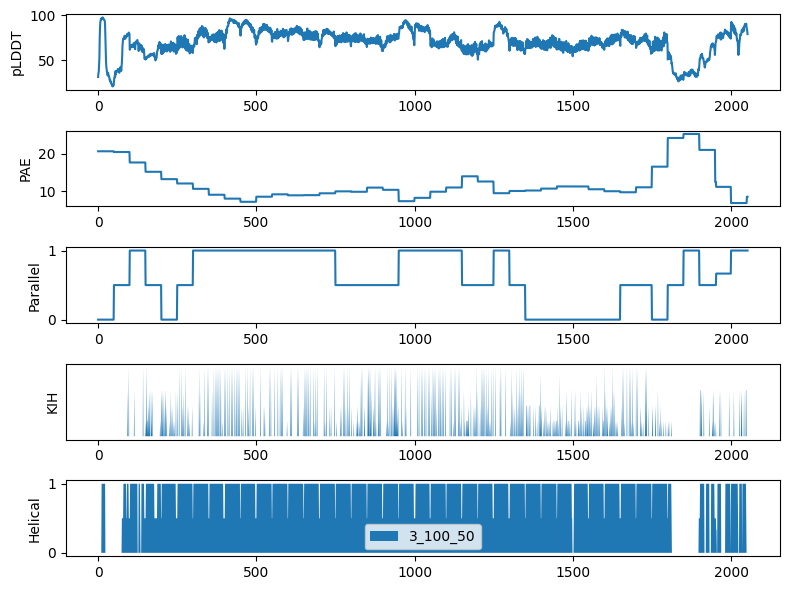

In [13]:
list_specifications = [i.replace('/','') for i in list_specifications if '_' in i]

fig, axarr = plt.subplots(nrows=5, ncols=1, figsize=(8,6))

for i_spec, specification in enumerate(list_specifications):
    axarr[0].plot(df_data_sequence[f'{specification}_plddt'], label=specification)
    axarr[1].plot(df_data_sequence[f'{specification}_pae'], label=specification)
    axarr[2].plot(df_data_sequence[f'{specification}_para']+0.04*i_spec, label=specification)
    kih_data = df_data_sequence[f'{specification}_kih'].to_numpy()
    # thresholding the data for visualization
    kih_data = np.minimum(kih_data, 1.5)
    axarr[3].fill_between(x=range(len(full_sequence)), y1=i_spec*2, y2=i_spec*2+kih_data, label=specification)
    heli_data = df_data_sequence[f'{specification}_heli']
    axarr[4].fill_between(x=range(len(full_sequence)), y1=i_spec*2, y2=i_spec*2+heli_data, label=specification)
        
    axarr[0].set_ylabel('pLDDT')
    axarr[1].set_ylabel('PAE')
    axarr[2].set_ylabel('Parallel')
    axarr[3].set_ylabel('KIH')
    axarr[3].set_yticks([])
    axarr[4].set_ylabel('Helical')

plt.legend()
plt.tight_layout()